In [ ]:
# @title Requirements
!pip install -qq roboflow ultralytics torch torchvision tensorflow pillow numpy opencv-python flask pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.7/91.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 130.7 MB/s eta 0:00:00


In [ ]:
# @title Imports
import os
from pathlib import Path
import cv2
import numpy as np
from zipfile import ZipFile
import shutil
import torch
import tensorflow as tf
from ultralytics import YOLO
from roboflow import Roboflow
from flask import Flask, request, jsonify
from pyngrok import ngrok
from google.colab import drive, userdata
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

os.chdir('/content')
OUTPUT_DIR = "/content/models"
DATASET_YOLO = "/content/dataset_yolo"
DATASET_CNN = "/content/dataset_cnn"
os.makedirs(OUTPUT_DIR, exist_ok=True)

YOLO_FILE_ID = "1D9alUhw0tQ9Z9vJru22H0NPPw7YZ3_PU"
CNN_FILE_ID = "1R4wd9tzUvJVR8dqGY9zlyIzHRS93Q4i3"

if not os.path.exists(DATASET_YOLO):
    !gdown --id {YOLO_FILE_ID} -O /content/dataset_yolo.zip
    with ZipFile("/content/dataset_yolo.zip", 'r') as zip_ref:
        zip_ref.extractall("/content")

    extracted_items = [d for d in os.listdir("/content") if d not in ["models", "sample_data", ".config"]]
    for item in extracted_items:
        item_path = f"/content/{item}"
        if os.path.isdir(item_path) and item != "dataset_yolo":
            if os.path.exists(f"{item_path}/data.yaml") or os.path.exists(f"{item_path}/train"):
                shutil.move(item_path, DATASET_YOLO)
                break

if os.path.exists(DATASET_YOLO) and not os.path.exists(f"{DATASET_YOLO}/valid"):
    if os.path.exists(f"{DATASET_YOLO}/test"):
        os.symlink(f"{DATASET_YOLO}/test", f"{DATASET_YOLO}/valid")

if not os.path.exists(DATASET_CNN):
    !gdown --id {CNN_FILE_ID} -O /content/dataset_cnn.zip
    with ZipFile("/content/dataset_cnn.zip", 'r') as zip_ref:
        zip_ref.extractall("/content")

    extracted_items = [d for d in os.listdir("/content") if d not in ["models", "dataset_yolo", "sample_data", ".config"]]
    for item in extracted_items:
        item_path = f"/content/{item}"
        if os.path.isdir(item_path) and item != "dataset_cnn":
            if os.path.exists(f"{item_path}/authentic") or os.path.exists(f"{item_path}/counterfeit"):
                shutil.move(item_path, DATASET_CNN)
                break

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1D9alUhw0tQ9Z9vJru22H0NPPw7YZ3_PU
From (redirected): https://drive.google.com/uc?id=1D9alUhw0tQ9Z9vJru22H0NPPw7YZ3_PU&confirm=t&uuid=6eaf54dd-719c-40af-88ea-763f848cc4fd
To: /content/dataset_yolo.zip
100% 178M/178M [00:02<00:00, 67.2MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need

In [ ]:
# @title YOLO Training
model = YOLO("yolov8n.pt")

results = model.train(
    data=f"{DATASET_YOLO}/data.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    name="medicine_yolo",
    project=OUTPUT_DIR
)

model.save(f"{OUTPUT_DIR}/medicine_yolo.pt")

metrics = model.val()
print(f"mAP50: {metrics.box.map50}")
print(f"mAP50-95: {metrics.box.map}")

Ultralytics 8.4.6 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset_yolo/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=medicine_yolo, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, pers

In [ ]:
# @title CNN Dataset setup
os.makedirs(f"{DATASET_CNN}/authentic", exist_ok=True)
os.makedirs(f"{DATASET_CNN}/counterfeit", exist_ok=True)

def crop_and_save(split="train"):
    images_dir = f"{DATASET_YOLO}/{split}/images"
    labels_dir = f"{DATASET_YOLO}/{split}/labels"

    for label_file in Path(labels_dir).glob("*.txt"):
        img_file = Path(images_dir) / f"{label_file.stem}.jpg"

        if not img_file.exists():
            continue

        img = cv2.imread(str(img_file))
        h, w = img.shape[:2]

        with open(label_file, "r") as f:
            for idx, line in enumerate(f.readlines()):
                parts = line.strip().split()
                class_id = int(parts[0])
                x_center, y_center, width, height = map(float, parts[1:])

                x1 = int((x_center - width/2) * w)
                y1 = int((y_center - height/2) * h)
                x2 = int((x_center + width/2) * w)
                y2 = int((y_center + height/2) * h)

                x1, y1 = max(0, x1), max(0, y1)
                x2, y2 = min(w, x2), min(h, y2)

                crop = img[y1:y2, x1:x2]

                class_name = "authentic" if class_id == 0 else "counterfeit"
                output_path = f"{DATASET_CNN}/{class_name}/{label_file.stem}_{idx}.jpg"
                cv2.imwrite(output_path, crop)

crop_and_save("train")
crop_and_save("valid")
crop_and_save("test")

print(f"Authentic crops: {len(list(Path(f'{DATASET_CNN}/authentic').glob('*.jpg')))}")
print(f"Counterfeit crops: {len(list(Path(f'{DATASET_CNN}/counterfeit').glob('*.jpg')))}")

Authentic crops: 7017
Counterfeit crops: 655


In [ ]:
# @title CNN Training Setup
IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    DATASET_CNN,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    DATASET_CNN,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)

base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

model_cnn = Model(inputs=base_model.input, outputs=predictions)

Found 6138 images belonging to 2 classes.
Found 1534 images belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# @title CNN Training
model_cnn.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history = model_cnn.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)
model_cnn.save(f"{OUTPUT_DIR}/medicine_cnn.h5")

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


Epoch 1/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 155s 673ms/step - accuracy: 0.9218 - loss: 0.2554 - val_accuracy: 0.8220 - val_loss: 0.5385
Epoch 2/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 85s 445ms/step - accuracy: 0.9737 - loss: 0.0830 - val_accuracy: 0.8038 - val_loss: 0.7336
Epoch 3/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 85s 444ms/step - accuracy: 0.9847 - loss: 0.0529 - val_accuracy: 0.7907 - val_loss: 0.9270
Epoch 4/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 85s 443ms/step - accuracy: 0.9876 - loss: 0.0422 - val_accuracy: 0.8188 - val_loss: 0.7966
Epoch 5/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 85s 446ms/step - accuracy: 0.9878 - loss: 0.0382 - val_accuracy: 0.8044 - val_loss: 0.9253
Epoch 6/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 85s 444ms/step - accuracy: 0.9917 - loss: 0.0272 - val_accuracy: 0.8031 - val_loss: 0.8908
Epoch 7/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 85s 444ms/step - accuracy: 0.9863 - loss: 0.0330 - val_accuracy: 0.8025 - val_loss: 1.0218
Epoch 8/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 85s 445ms/step - accuracy: 0.9919 - loss: 

In [ ]:
import shutil
from google.colab import files

# Create a zip archive of the models folder
zip_file_path = shutil.make_archive("/content/models", "zip", OUTPUT_DIR)
print(f"Models folder zipped to: {zip_file_path}")

# Verify the zip file exists and offer it for download
if os.path.exists(zip_file_path):
    print("\nDownloading the models.zip file...")
    files.download(zip_file_path)
else:
    print("Error: models.zip file not found.")

Models folder zipped to: /content/models.zip



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Testing: images329_jpg.rf.189041093ca5d24ba6269d4021ff5a28.jpg



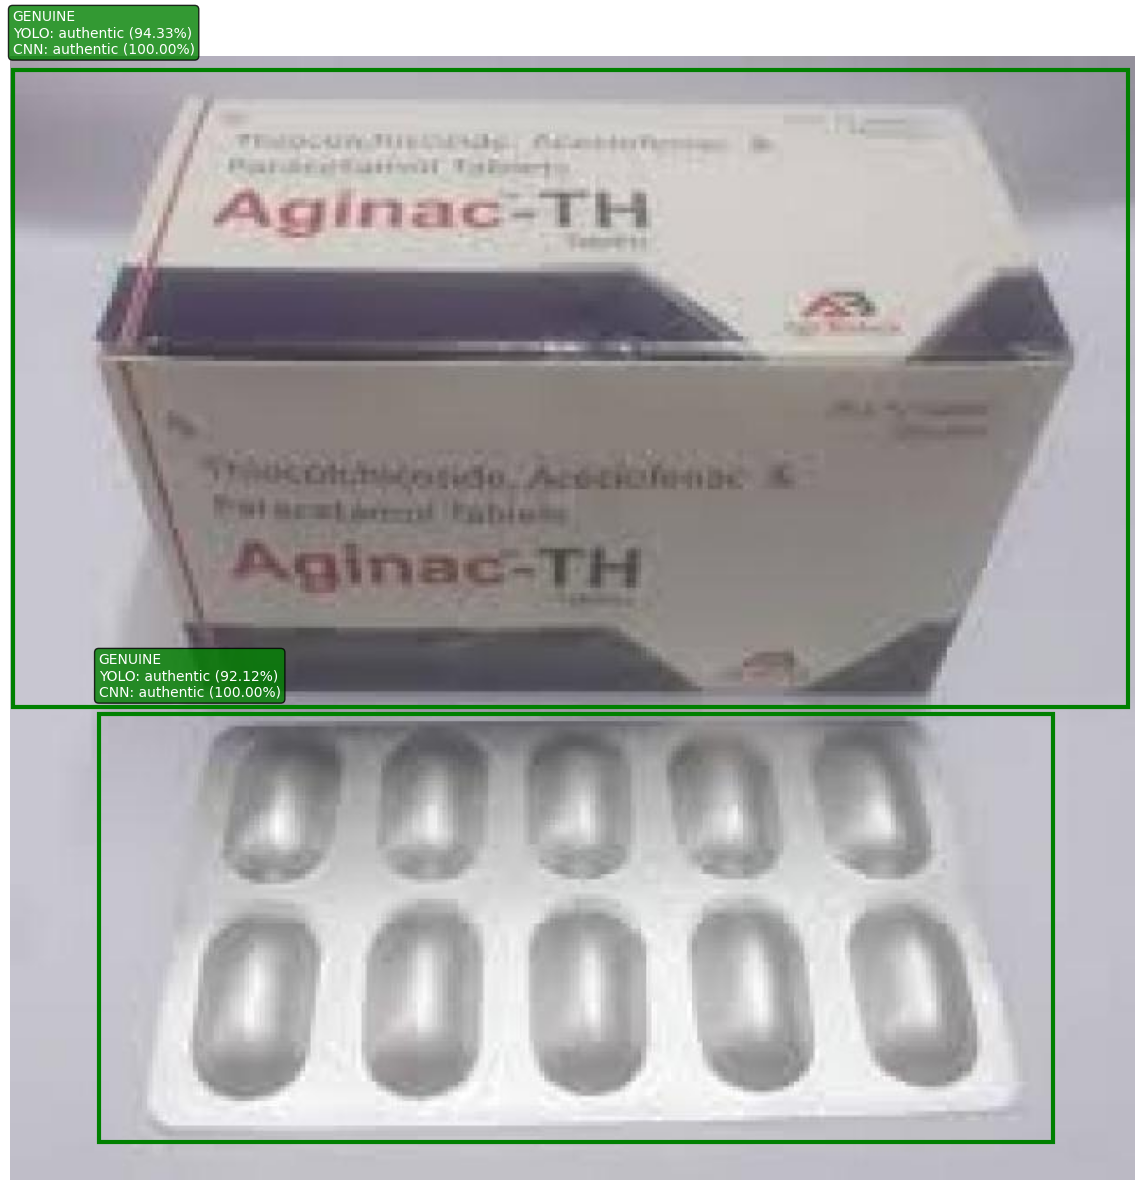

In [ ]:
# @title Test Verification
import matplotlib.pyplot as plt
import matplotlib.patches as patches

yolo_model = YOLO(f"{OUTPUT_DIR}/medicine_yolo.pt")
cnn_model = tf.keras.models.load_model(f"{OUTPUT_DIR}/medicine_cnn.h5")

test_images_dir = Path(f"{DATASET_YOLO}/test/images")
test_images = list(test_images_dir.glob("*.jpg"))

if len(test_images) == 0:
    print("No test images found!")
else:
    test_image_path = test_images[0]
    print(f"Testing: {test_image_path.name}\n")

    image = cv2.imread(str(test_image_path))

    if image is None:
        print("Failed to load image!")
    else:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        yolo_results = yolo_model.predict(image, verbose=False)

        if len(yolo_results[0].boxes) == 0:
            plt.figure(figsize=(10, 10))
            plt.imshow(image_rgb)
            plt.axis('off')
            plt.title("No packages detected", fontsize=14)
            plt.show()
        else:
            fig, ax = plt.subplots(1, figsize=(12, 12))
            ax.imshow(image_rgb)

            for idx, box in enumerate(yolo_results[0].boxes):
                x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
                yolo_class = int(box.cls[0])
                yolo_conf = float(box.conf[0])
                yolo_label = "authentic" if yolo_class == 0 else "counterfeit"

                crop = image[y1:y2, x1:x2]
                crop_resized = cv2.resize(crop, (IMG_SIZE, IMG_SIZE))
                crop_array = crop_resized.astype("float32") / 255.0
                crop_array = np.expand_dims(crop_array, axis=0)

                cnn_pred = cnn_model.predict(crop_array, verbose=0)
                cnn_class = np.argmax(cnn_pred[0])
                cnn_conf = float(np.max(cnn_pred[0]))
                cnn_label = "authentic" if cnn_class == 0 else "counterfeit"

                if yolo_label == cnn_label and cnn_conf > 0.8:
                    final_result = "GENUINE" if yolo_label == "authentic" else "COUNTERFEIT"
                    color = 'green' if final_result == "GENUINE" else 'red'
                else:
                    final_result = "SUSPICIOUS"
                    color = 'orange'

                rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=3, edgecolor=color, facecolor='none')
                ax.add_patch(rect)

                label_text = f"{final_result}\nYOLO: {yolo_label} ({yolo_conf:.2%})\nCNN: {cnn_label} ({cnn_conf:.2%})"
                ax.text(x1, y1-10, label_text, color='white', fontsize=10,
                       bbox=dict(boxstyle='round', facecolor=color, alpha=0.8))

            ax.axis('off')
            plt.tight_layout()
            plt.show()

In [ ]:
# @title Server
NGROK_AUTHTOKEN = userdata.get('NGROK_AUTHTOKEN')
ngrok.set_auth_token(NGROK_AUTHTOKEN)
app = Flask(__name__)

YOLO_MODEL_PATH = "models/medicine_yolo.pt"
CNN_MODEL_PATH = "models/medicine_cnn.h5"

yolo_model = None
cnn_model = None

def load_models():
    global yolo_model, cnn_model
    if os.path.exists(YOLO_MODEL_PATH):
        yolo_model = YOLO(YOLO_MODEL_PATH)
        print("YOLO model loaded")
    if os.path.exists(CNN_MODEL_PATH):
        cnn_model = tf.keras.models.load_model(CNN_MODEL_PATH)
        print("CNN model loaded")

def verify_image(image_array):
    if yolo_model is None or cnn_model is None:
        return {
            "status": "error",
            "message": "Models not loaded",
            "result": None,
            "confidence": 0.0,
            "detections": []
        }

    results = yolo_model.predict(image_array, verbose=False)

    if len(results[0].boxes) == 0:
        return {
            "status": "success",
            "message": "No packages detected",
            "result": None,
            "confidence": 0.0,
            "detections": []
        }

    detections = []

    for box in results[0].boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        yolo_class = int(box.cls[0])
        yolo_conf = float(box.conf[0])
        yolo_label = "authentic" if yolo_class == 0 else "counterfeit"

        crop = image_array[y1:y2, x1:x2]
        crop_resized = cv2.resize(crop, (IMG_SIZE, IMG_SIZE))
        crop_array = crop_resized.astype("float32") / 255.0
        crop_array = np.expand_dims(crop_array, axis=0)

        cnn_pred = cnn_model.predict(crop_array, verbose=0)
        cnn_class = np.argmax(cnn_pred[0])
        cnn_conf = float(np.max(cnn_pred[0]))
        cnn_label = "authentic" if cnn_class == 0 else "counterfeit"

        if yolo_label == cnn_label and cnn_conf > 0.8:
            final_result = "GENUINE" if yolo_label == "authentic" else "COUNTERFEIT"
        else:
            final_result = "SUSPICIOUS"

        detections.append({
            "bbox": [x1, y1, x2, y2],
            "yolo_label": yolo_label,
            "yolo_confidence": yolo_conf,
            "cnn_label": cnn_label,
            "cnn_confidence": cnn_conf,
            "result": final_result
        })

    return {
        "status": "success",
        "message": "Verification complete",
        "result": detections[0]["result"] if len(detections) == 1 else "MULTIPLE_PACKAGES",
        "confidence": detections[0]["cnn_confidence"] if len(detections) == 1 else 0.0,
        "detections": detections
    }

@app.route("/", methods=["GET"])
def hello():
    return jsonify({
        "status": "success",
        "message": "Medicine AI Vision Server is running",
        "service": "vision-inspection"
    })


@app.route("/health", methods=["GET"])
def health():
    return jsonify({
        "status": "healthy",
        "service": "vision-inspection"
    })


@app.route("/api/verify", methods=["POST"])
def verify_package():
    if "image" not in request.files:
        return jsonify({
            "status": "error",
            "message": "No image provided"
        }), 400

    image_file = request.files["image"]
    image_bytes = image_file.read()
    nparr = np.frombuffer(image_bytes, np.uint8)
    image_array = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

    if image_array is None:
        return jsonify({
            "status": "error",
            "message": "Invalid image format"
        }), 400

    result = verify_image(image_array)
    return jsonify(result)


if __name__ == "__main__":
    port = 5000

    load_models()

    public_url = ngrok.connect(port)
    print(f"Ngrok Tunnel URL: {public_url}")
    print(f"Add this URL to your Django .env file as COLAB_API_URL")

    app.run(port=port)


YOLO model loaded


CNN model loaded
Ngrok Tunnel URL: NgrokTunnel: "https://merrie-superprepared-tamela.ngrok-free.dev" -> "http://localhost:5000"
Add this URL to your Django .env file as COLAB_API_URL
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
ERROR:root:Unexpected exception finding object shape
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/google/colab/_debugpy_repr.py", line 54, in get_shape
    shape = getattr(obj, 'shape', None)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/werkzeug/local.py", line 318, in __get__
    obj = instance._get_current_object()
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/werkzeug/local.py", line 519, in _get_current_object
    raise RuntimeError(unbound_message) from None
RuntimeError: Working outside of request context.

This typically means that you attempted to use functionality that needed
an active HTTP request. Consult the documentation on testing for
information abo